# Problem set 8. Governance & Prosperity

## 0. Background

These problem set assignments are a required part of the course.

Collaborating on the problem sets is more than okay—it is encouraged! Seek help from a classmate or an instructor or a roommate or a passerby when you get stuck! (Explaining things is beneficial, too—the best way to solidify your knowledge of a subject is to explain it.) 

But the work should be your own.

No cutting-&-pasting from others' problem sets, please! We want you to learn this stuff, and your fingers typing every keystroke is an important way of building muscle memory here.

In this problem set, you will investigate whether quality of governance is an important cause or consequence of prosperity. This problem set is adapted from one at Quantecon, by John Stachurski and Thomas Sargent: _Linear Regression in Python_ <https://python.quantecon.org/ols.html>

This is an odd problem set. I lead you through the analysis, but there is relatively little programming for you to do. Thus grading will be based overwhelmingly on the 250-500 word answer you give in 6.D, interpreting the analysis I have led you through.

Let us get started!

&nbsp;

## 1. Preliminaries: Computing Environment

First, we set up the computing environment with the libraries we need: 

In [1]:
# 8.1.1. set up the computing environment: ensure that graphs
# appear inline in the notebook & not in extra windows:

%matplotlib inline

In [2]:
# 8.1.2. set up the computing environment: import standard libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# 8.1.3. set up the computing environment: additional library: linear models:

!pip install linearmodels
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

## 2. Assertions...

### A. Governance & Prosperity

How much of the wide divergence in income and prosperity across countries in the world today reflects good and bad domestic political luck? 

**Daron Acemoglu, Simon Johnson, & James Robinson**, writing in 2000 in their _The Colonial Origins of Comparative Development: An Empirical Investigation_ <https://github.com/braddelong/public-files/blob/master/readings/article-acemoglu-colonial-origins.pdf>, conclude: a lot. 

In their view, whether a country has good governance—that encourages economic growth, encourages investment through protecting property rights, and is relatively uncorrupt—hinges on the luck of its history. Did it develop institutions that were good for growth, both as a result of the push and pull of politically powerful actors and because of far-sighted decisions by statesmen and stateswomen? Or did it not not?

&nbsp;

### B. The AJR Argument

To understand the argument, let's download the data of **Daron Acemoglu, Simon Johnson, & James Robinson** (2000): _The Colonial Origins of Comparative Development: An Empirical Investigation_ <https://github.com/braddelong/public-files/blob/master/readings/article-acemoglu-colonial-origins.pdf>and take a look at the basic scatter of properity and "governance". The computer plots the quality of governance as estimated by Political Risk Services on the horizontal axis, and the logarithm of real income per capita in the country in 1995 on the vertical axis:

In [4]:
# 8.2.B.1. download the ajr data & look at the basic scatter:
#
# 'governancequality' is as perceived over 1985-1995
# by the PRS Group <https://www.prsgroup.com>
#
# 'logincome' is year-1995 real income per capita
#
# start by reading in the AJR data from the internet:

ajr_df = pd.read_csv('https://delong.typepad.com/files/ajr-2020.csv')

ajr_df.head()

,shortid,europeanancestry1900,excolony,governancequality,logincome,logsettlermortality,loghjypl,basesample
0,AFG,0.000000,1.0,NaN,NaN,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN


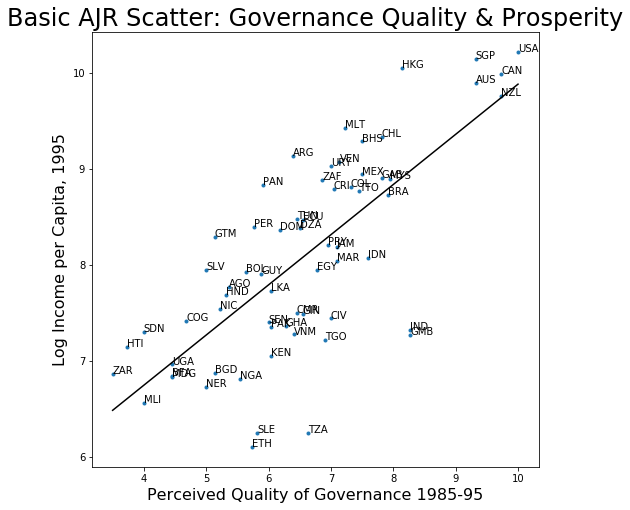

In [20]:
# drop missing observations:

ajr_df = ajr_df.dropna(subset=['logincome', 'governancequality'])

# restrict our analysis to the AJR "base" sample:

ajr_df = ajr_df[ajr_df['basesample'] == 1]

# tell python to expect figures to come 
# by initializing the python objects to hold the figures...

fig, ax = plt.subplots(figsize=(8,8)) 

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(ajr_df['governancequality'], ajr_df['logincome'], marker='.')

# now loop through the data[points in the figure, annotating each
# data point with a three letter code ('Threeletterabbrevation') identifying the 
# country refered to:

for i, txt in enumerate(ajr_df['shortid']):
    ax.annotate(txt, (ajr_df['governancequality'].iloc[i], ajr_df['logincome'].iloc[i]))
    

# draw a straight least-squares fit line through the data

ax.plot(np.unique(ajr_df['governancequality']),
    np.poly1d(np.polyfit(ajr_df['governancequality'], ajr_df['logincome'], 1))(np.unique(ajr_df['governancequality'])),
    color='black')

# set the figure labels, and show the figure:


ax.set_xlabel('Perceived Quality of Governance 1985-95', size=16)
ax.set_ylabel('Log Income per Capita, 1995', size=16)
ax.set_title('Basic AJR Scatter: Governance Quality & Prosperity', size=24)
plt.show()

## 3. Statistics...

Note the "least-squares fit line": the computer has calculated and drawn a line according to an equation:

>$ logincome =  \hat{\beta}_{const} + \hat{\beta}_{governancequality}(governancequality) $

What is this "least-squares fit line?" It draws the line for which, when you take the vertical distances from each of the data points to the line, square the distances, and then add them up, that sum is least. In order to draw the line, the computer has to choose two parameters. The first is $ \hat{\beta}_{const} $, a "constant" term: changing it shifts the line up and down, and when it is equal to zero the line must go through the (0,0) point on the graph. The second is $ \hat{\beta}_{governancequality} $, the amount by which a one-unit increase in the variable on the x-axis raises the value of the variable on the y-axis: changing it tilts the line.

Drawing this least-squares fit line is a good thing to do if the data-generating process is composed of (a) a linear straight-line relationship between the x-axis and the y-axis variables, plus (b) an extra ("disturbance") term raising or lowering the y-axis value by a random amount that has a _normal distribution_. Such a normal ditribution means "thin tails": that is, the chance that an observation will be very far from the underlying relationship between the x-axis and y-axis variables is very small, and that chance decreases very very rapidly indeed as you get further away.

Drawing this kind of least-squares best-fit line is called, in statistics, a "regression analysis". If we ask, the computer can tell us a number of things about the statistical characteristics of the line it has just drawn:

In [6]:
# 8.3.1. since we do not want the relationship between x and y
# to be forced to go through the point (0,0) on the graph,
# we add a variable that is a constant—always equal to one—
# to our dataframe
#
# thus as the computer hunts for the linear best-fit liine we
# allow it both to change the slope of the fitted line and 
# to move it up or down to find the least-squares best fit:

ajr_df['constant'] = 1

print('REGRESSION OF PROSPERITY ON GOVERNANCE QUALITY')

print(sm.OLS(endog=ajr_df['logincome'], 
                exog=ajr_df[['constant', 'governancequality']], 
                missing='drop').fit().summary())

REGRESSION OF PROSPERITY ON GOVERNANCE QUALITY
                            OLS Regression Results                            
Dep. Variable:              logincome   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     72.82
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           4.72e-12
Time:                        08:14:35   Log-Likelihood:                -68.168
No. Observations:                  64   AIC:                             140.3
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Here:

* "sm" is the "statsmodels" package applications programming interface that we loaded earlier;
* "OLS" means that we are carrying out a least-squares fit in the "ordinary" O (as opposed to, say, a "two stage" 2S) analysis;
* "endog = ajr_df['logincome']" says that the thing we are trying to predict, analyze, and understand is the "logincome" variable in the "ajr_df" dataframe;
* "exog = ajr_df['constant', 'governancequality']" says that we are assuming that logincome is determined by the "governancequality" quality-of-governance variable and the constant term (so that logincome does not have to be zero when avgexpr is zero) in the "ajr_df" dataframe;
* "missing = drop" means that we drop from the analysis any observations—dataframe rows—in which some values of the data are missing;
* "fit" means that we want to look at how well the least-squares line does at "fitting" the data;
* "summary" means that we only want to look at the summary table;
* and "print" means that we want the analysis printed out to the screen so that we can look at it.

For our purposes, there are three most important numbers to look at in this table. 

The first, the first is the 0.540 labeled "R-squared" in the top-right. 

This tells us the proportion of the variation in the variable we are trying to understand—logincome, the log of real income per capita in 1995—that we could forecast if we knew the least-squares line and knew that country's values of our predictor variables—the constant, and the quality of governance avgexpr. The 0.522 tells us that, if quality of governance as we have estimated it is the only systematic determinant of log income per capita, that 52.2% of the variation in log income per capita is accounted for by the variation in quality of governance, and the rest is random variation.

The second number is the 0.644 on the right, just above the third line of equals signs "...======". 

It tells us that, if this regression analysis is correctly specified (i.e., quality of governance as we have estimated it is the only systematic determinant of log income per capita), and if the random disturbances to log income per capita have nothing to do with each other (are "independent"), and if these disturbances have a normal distribution ("thin tales"), and if the data were generated starting from values of the constant and of governance quality governancequality by the equation:

>$ logincome =  \beta_{const} + \beta_{governancequality}(governancequality) + \epsilon $

where the $ \epsilon $ is the independent normally-distributed random disturbance,

then there is only a 2.5% chance that the "true" $ \beta_{governancequality} $ that generated the data is greater than 0.644.

(Or, rather, only a 2.5% chance that 0.644 is greater than the "true" $ \beta $ that generated the data. The true $ \beta $ is what it is, and is not affected by what the data turned out to be. The 0.644 is a random variable that could have been high and could have been low. There was only a 2.5% chance that it would be higher than the true $ \beta_{governancequality} $. But now that it has been calculated and realized, it is either higher than the true $ \beta $ or it is not—but since you do not know the true $ \beta_{governancequality} $, you do not know which is the case.)

Now this 0.644 has a somewhat strange ontological status. It is a number that is "true" if a number of other things are true none of which are true: quality of governance is not the only systematic determinant, the random disturbances are not independent, they do not have a normal distribution, and the data were not generated by the equation. Thus assessing the relationship between the number and our reality requires some thought.

The third number is the 0.400. It is the cousin of the 0.644. If there really were only a 2.5% chance that when you calculated the number that turned out to be 0.644 it would be higher than the true $ \beta $, there would similarly be only a 2.5% chance that when you calculated the number that turned out to be 0.400 it would be lowere than the true $ \beta $.

We call the range [0.400, 0.644] the *confidence interval*. And we say that it is statistically unlikely that this randomly generated confidence interval that is a function of how pure chance generated the disturbance causes of real income per capita lies entirely outside of the true $ \beta $. Whenever zero is not included in the confidence interval, people tend to say that that fact is "statistically significant". But it is better to avoid saying that, as it tends to lead to very fuzzy and misleading thinking.

&nbsp;

## 4. Quantitative Relationships...

Now let's, for a moment, put aside all the statistical uncertainty issues. Let us suppose that the values of the equation:

>$ logincome =  \hat{\beta}_{constant} + \hat{\beta}_{governancequality}(governancequality) $

that our statistical analysis has estimated are the true values, and they are as given by the first numbers in the lines that start with "constant" and "governancequality":

>$ \hat{\beta}_{constant} = 4.6604 $    
$ \hat{\beta}_{governancequality} = 0.5221 $

Thus if governance quality were zero, we would expect the log of income per capita to be 4.66. And we would expect every one-unit increase in governance quality to carry with it an 0.522 increase in the log of income per capita.

What does such an equation mean?

First, what does a log of 4.6604 mean? Let's calculate it in the cell below:

In [7]:
# 8.4.1. calculate the annual per-capita income level for which log income per capita is 4.6604

y_4point6 = np.exp(4.6604) # REMOVE THIS BEFORE DEPLOYMENT

# y_4point6 UNCOMMENT THIS

print("$",y_4point6, "/per year   is the annual income per capita level for which logincome is 4.6604" )

$ 105.67834504153564 /per year   is the annual income per capita level for which logincome is 4.6604


But we do not get governance quality scores less than 4. What is the same calculation for a governance quality score of 4, given our two parameters 4.66 and 5.22:

In [8]:
# 8.4.2. calculate the expected annual per-capita income level for a governance-quality index of 4

y_govqualis4 = np.exp(4.6604 + 0.5221*4) # DELETE THIS BEFORE DEPLOYMENT
# y_govqualis4 = ... UNCOMMENT THIS BEFORE DEPLOYMENT

print("$",y_govqualis4, "/per year   is the annual income per capita level for a governance-quality index of 4")

$ 853.0345066875342 /per year   is the annual income per capita level for a governance-quality index of 4


That is a near-subsistence income: 2.35 dollars a day per person. 

Since the y variable is a logarithm, recognize that each 0.522 arithmetic increase in the log as governance quality increases unit by unit is an equal multiplicative factor applied to income per capita. Let's calculate what that multiplicative factor is:

In [9]:
# 8.4.3. by what factor is expected income multiplied when governance quality is increased by one unit?

oneunitincomemult = np.exp(0.522) # DELETE THIS BEFORE DEPLOYMENT
# oneunitincomemult = ... UNCOMMENT THIS BEFORE DEPLOYMENT

print("Increasing governance quality by one multiplies expected income by a factor of:", oneunitincomemult)

Increasing governance quality by one multiplies expected income by a factor of: 1.6853950712974088


These effects multiply. Let's print out what we expect income per capita to be for each governance-quality integer value from 4 to 10 inclusive:

In [10]:
# 8.4.4. expected per-capita income as governance quality varies from 4 to 10

govqual = []
expinc = []

for i in range(7):
    govqual = govqual + [i+4]
#    expinc = expinc + [...] UNCOMMENT THIS BEFORE DEPLOYMENT 
    expinc = expinc + [np.exp(4.6604 + (i+4)*0.522)] # DELETE THIS BEFORE DEPLOYMENT
    
for i in range(7):    
    print("For a governance quality of", govqual[i], ", expected income per capita is:", expinc[i]) 



For a governance quality of 4 , expected income per capita is: 852.6933611185216
For a governance quality of 5 , expected income per capita is: 1437.1251881571782
For a governance quality of 6 , expected income per capita is: 2422.12370895747
For a governance quality of 7 , expected income per capita is: 4082.235361149513
For a governance quality of 8 , expected income per capita is: 6880.179357557402
For a governance quality of 9 , expected income per capita is: 11595.820378869399
For a governance quality of 10 , expected income per capita is: 19543.538514196578


so that by the time we reach a pair of countries whose risk of appropriation scores differ by 6, the fitted relationship associates that with a difference in real per capita income of a factor of 23: the richer country is 23 times richer than the poorer one, according to the line of best fit. And that is the difference that is associated with the difference between a governance-quality index of 4 and a governance-quality index of 10, between a Haiti and a New Zealand.

&nbsp;

## 5. Directions of Causation...

But which way does cause run? Is governance quality the cause, and prosperity the effect? Or is it prosperity—or the other factors that truly drive prosperity—that is the cause, and governance quality that is the effect? What happens if what you conduct an analysis, but what you think is cause is really effect?

### A. Underlying Structure...

Let us try to think through this issues. Let us, for the moment, assume that the level of prosperity Y is indeed determined by good governanCe G and by other, random, disturbance factors that we gather together and add up into the random variable which we call $ \epsilon $. What is this random variable $ \epsilon $ ? It is a thing that varies, randomly—that we cannot predict from inside the system. So we write:

$ Y = \beta G + \epsilon $    

And let us also assume, again for the moment, that prosperity Y causes high governance quality G—that prosperity leads to a society in which people have the resources and the voice and the power to demand good governance:

$ G = \gamma( Y +  \nu ) $

Where here the other causes of governance quality G than prosperity Y are gathered into another random variable which we call $ \nu $ which, again, varies, randomly, and which we cannot predict from inside the system. 

Then if we solve for what Y and G are as functions of our random variables $ \epsilon $ and $ \nu $, we get:

$ Y = \frac{1}{1 - \beta\gamma}\epsilon + \frac{\beta\gamma}{1 - \beta\gamma} \nu $    
$ G = \frac{\gamma}{1 - \beta\gamma}\epsilon + \frac{\gamma}{1 - \beta\gamma} \nu  $

Now we can start analyzing what we would expect a linear regression analysis like that of 8.3 to report about the relationship between G and Y. 

### B. How a Regression Analysis Calculates $ \beta $...

We can think of how the linear regression analysis calculates $ \beta $ this way:

1. The analysis starts as multiplying G by Y and then taking its "expectation" (we have to take expectations, because both P and Y are determined by these $ \epsilon $ and $ \nu $ objects that are varying randomly, so all we can say is what we expect them to be).
2. The analysis continues by multiply P by multiplying itself and take its expectation
3. The analysis then divides the first by the second: 

In doing this calculation, the normal rules of arithmetic apply, with some added weirdness. There are five points of added weirdness:

1. We write $ \sigma^2_{P} $ for our expectation of P multiplied by itself—but instead of saying "what we expect the variation in P times itself to be", we say that this is the *variance* of P.

2. We write $ \sigma_{YP} $ for our expectation of P multiplied by Y—but instead of saying "what we expect the variation in P times Y to be", we say that this is the *covariance* of P and Y.

3. We, similarly to (1), write $ \sigma^2_{\epsilon} $ for our expectation of $ \epsilon $ multiplied by itself—but instead of saying "what we expect the variation in $ \epsilon $ times itself to be", we say that this is the *variance* of $ \epsilon $.

4. We, similarly to (1), write $ \sigma^2_{\nu} $ for our expectation of $ \nu $ multiplied by itself—but instead of saying "what we expect the variation in $ \nu $ times itself to be", we say that this is the *variance* of $ \nu $.

5. Wherever we are taking the expectation of something that has an $ \epsilon $ multiplied by a $ \nu $ in it, we set it equal to zero: $ \sigma_{\epsilon\nu} = 0 $

Applying these rules—and the normal rules of arithmetic—we can then calculate:

First: $ \sigma_{YP} = \left[ \gamma \sigma^2_{\epsilon} + \beta \gamma^2 \sigma^2_{\nu} \right] \left[\frac{1}{1-\beta\gamma}  \right]^2 $

Second: $ \sigma_{PP} = \left[ \gamma^2 \sigma^2_{\epsilon} + \gamma^2 \sigma^2_{\nu} \right] \left[\frac{1}{1-\beta\gamma}  \right]^2 $

Third: $ \frac{ \sigma_{YP}}{\sigma_{PP}} =  
\frac {\gamma \sigma^2_{\epsilon} + \beta \gamma^2 \sigma^2_{\nu}}   
{\gamma^2 \sigma^2_{\epsilon} + \gamma^2 \sigma^2_{\nu}} $

This last is what we expect the linear regression analysis to produce: we expect the $ \hat{\beta} $ produced by the regression analysis to be:

>$ \hat{\beta} = \frac{ \sigma_{YP}}{\sigma_{PP}} $

It is convenient define a quantity that is the ratio of the two kinds of random variation in the model: $ \rho = \frac{\sigma^2_{\nu}} {\sigma^2_{\epsilon}} $. 

Then: $  \hat{\beta} = \frac{\sigma_{YP}}{\sigma_{PP}} = 
 \left( \frac{ \rho}{1 + \rho} \right) \beta +  \left( \frac{1 }{1  + \rho} \right) \frac{1}{\gamma}
$

The OLS regression coefficient $ \hat{\beta} $ is thus expected to be a weighted average of the true $ \beta $ causal relationship between G and Y on the one hand, and the $ \frac{1}{\gamma} $ reverse-causation confounding term back from Y to G on the other. The weights in this weighted average depending on how much variation there is in the other things in the past or present that independently affect G, $ \nu $, relative to how much variation there is the other things $ \epsilon $ that determine prosperity besides governance quality.

Alternatively we could write:

$  \hat{\beta} - \beta =  
 \left( \frac{1 }{1  + \rho} \right) \left( \frac{1}{\gamma} - \beta \right)
$

### C. What $\hat{\beta} = 0.522 $  Tells Us...

We do not know either $ \rho $—the relative variability of the other factors that are determining G or Y—or $ \gamma $—the strength of the causal forces leading good governance to be a result of prosperity. AJR worry that their impressive scatter is a result of this reverse causation.

What can we say about it?

First, if $ \gamma = 0 $—if there is no reverse causation from prosperity to governance quality—then we expect the true $ \beta = \hat{\beta} = 0.522 $. There is no problem. So let's consider only what might go wrong with our analysis when $ \gamma ≠ 1 $.

Second, we are fine either if $ | \beta - 1/\gamma | $ is small or if $ \rho $ is sufficiently large. Only when $ \rho $ is not sufficiently large and $ | \beta - 1/\gamma | $ is not small do we run into problems. 

What can we say about what the true $ \beta $ might be, given our $ \hat{\beta} = 0.522 $, when $ \rho $ is not large run and $ | \beta - 1/\gamma | $ is not small?

This is what a computer is good for. Let's consider some scenarios—the first one with the true $ \gamma = 1 $—and see how different values of $ \rho $ lead us to expect to get different values of $ \hat{beta} $:

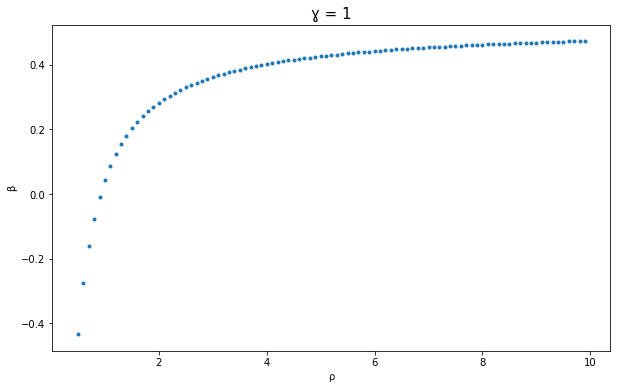

In [11]:
# 8.5.C.1. ɣ=1 case

beta_hat = 0.522
gamma = 1
rho_series = []
beta_series = []

for i in range(5,100):
    rho = i/10
    beta =  ((1 + rho)/rho)*beta_hat - (1/gamma)/rho
    rho_series = rho_series + [rho]
    beta_series = beta_series + [beta]
    

fig, ax = plt.subplots(figsize=(10,6)) 

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(rho_series, beta_series, marker='.')

ax.set_xlabel('⍴', size=10)
ax.set_ylabel('β', size=10)
ax.set_title('ɣ = 1', size=15)
plt.show()

See from the chart that, with ɣ = 1, if the variances are equal—if ⍴ = 1—then the finding that  $ \hat{\beta} = 0.522 $ means that, in truth, there is no causal relationship between governance and prosperity. Even though it looks like there is, all of it is due to reverse causality, and none of the relationship is due to good governance causing greater prosperity.

What is our regression analysis likely to find if ɣ = 1/4? In the code cell below program up the chart creation process analogous to the one above, and then look at the answer:

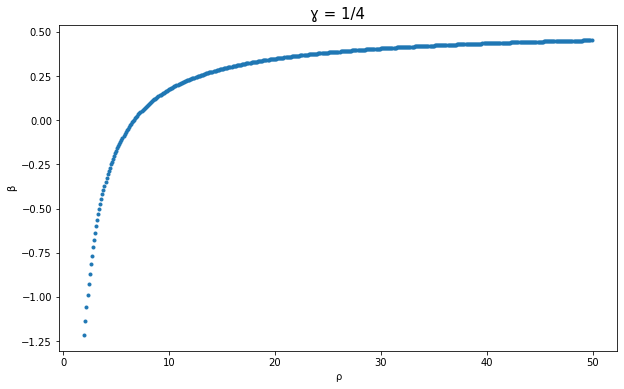

In [12]:
# 8.5.C.2. ɣ = 1/4 case

# ...
# ...
# ...
# ...

# for...
#    ...
#    ...
#    ...
#    ...

# ...
# ...
# ...
# ...
# ...
# ...

beta_hat = 0.522 # DELETE BEFORE DEPLOYING
gamma = 0.25 # DELETE BEFORE DEPLOYING
rho_series = [] # DELETE BEFORE DEPLOYING
beta_series = [] # DELETE BEFORE DEPLOYING

for i in range(20,500): # DELETE BEFORE DEPLOYING
    rho = i/10 # DELETE BEFORE DEPLOYING
    beta =  ((1 + rho)/rho)*beta_hat - (1/gamma)/rho # DELETE BEFORE DEPLOYING
    rho_series = rho_series + [rho] # DELETE BEFORE DEPLOYING
    beta_series = beta_series + [beta] # DELETE BEFORE DEPLOYING
    

fig, ax = plt.subplots(figsize=(10,6))  # DELETE BEFORE DEPLOYING

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(rho_series, beta_series, marker='.') # DELETE BEFORE DEPLOYING

ax.set_xlabel('⍴', size=10) # DELETE BEFORE DEPLOYING
ax.set_ylabel('β', size=10) # DELETE BEFORE DEPLOYING
ax.set_title('ɣ = 1/4', size=15) # DELETE BEFORE DEPLOYING
plt.show() # DELETE BEFORE DEPLOYING

How about if ɣ = 10? Once again, program up the chart creation, and look at it:

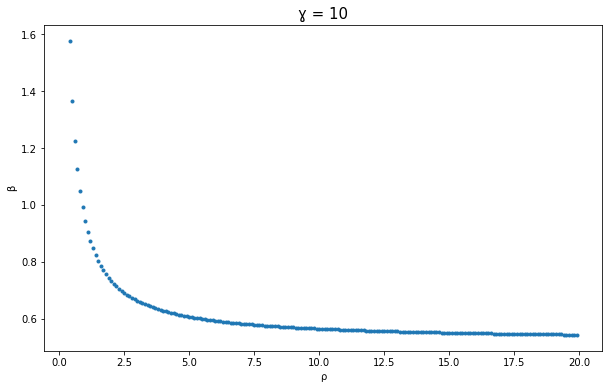

In [13]:
# 8.5.C.3. ɣ = 10 case

# ...
# ...
# ...
# ...

# for...
#    ...
#    ...
#    ...
#    ...

# ...
# ...
# ...
# ...
# ...
# ...

beta_hat = 0.522 # DELETE BEFORE DEPLOYING
gamma = 10 # DELETE BEFORE DEPLOYING
rho_series = [] # DELETE BEFORE DEPLOYING
beta_series = [] # DELETE BEFORE DEPLOYING

for i in range(4,200): # DELETE BEFORE DEPLOYING
    rho = i/10 # DELETE BEFORE DEPLOYING
    beta =  ((1 + rho)/rho)*beta_hat - (1/gamma)/rho # DELETE BEFORE DEPLOYING
    rho_series = rho_series + [rho] # DELETE BEFORE DEPLOYING
    beta_series = beta_series + [beta] # DELETE BEFORE DEPLOYING
    

fig, ax = plt.subplots(figsize=(10,6))  # DELETE BEFORE DEPLOYING

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(rho_series, beta_series, marker='.') # DELETE BEFORE DEPLOYING

ax.set_xlabel('⍴', size=10) # DELETE BEFORE DEPLOYING
ax.set_ylabel('β', size=10) # DELETE BEFORE DEPLOYING
ax.set_title('ɣ = 10', size=15) # DELETE BEFORE DEPLOYING
plt.show() # DELETE BEFORE DEPLOYING

If ɣ is high—if the quality of governance is strongly caused by prosperity—then the estimated $ \hat{\beta} $ is not an over-but an underestimate of the true causal relationship running from quality of governance to prosperity.

Alternatively, we could consider a fixed value for the variability ratio $ \rho $, and examine how the true $ \beta $ would be different for different values of the strength ɣ of the reverse-causation channel, like this:

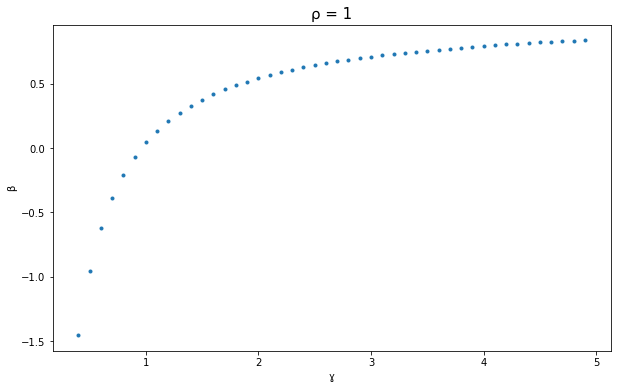

In [26]:
# 8.5.C.4. ⍴=1 case

beta_hat = 0.522
rho = 1
gamma_series = []
beta_series = []

for i in range(4,50):
    gamma = i/10
    beta =  ((1 + rho)/rho)*beta_hat - (1/gamma)/rho
    gamma_series = gamma_series + [gamma]
    beta_series = beta_series + [beta]
    

fig, ax = plt.subplots(figsize=(10,6)) 

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(gamma_series, beta_series, marker='.')

ax.set_xlabel('ɣ', size=10)
ax.set_ylabel('β', size=10)
ax.set_title('⍴ = 1', size=15)
plt.show()

As ɣ—the strength of the reverse-causation channel from prosperity back to high-quality governance—varies from 0.4 to 5, then, for a variance ratio ⍴ = 1, an estimated $ \hat{\beta} = 0.522 $ can be associated with a true β strength of the causal relationship from governance to prosperity varying from -1.5 up to 0.8.

We need to have a strong and informed view about both the value of ɣ, the strength of the reverse-causation channel from prosperity back to high-quality governance, and of ⍴, the ratio of the variations, in order to judge what the $ \hat{\beta} = 0.522 $ tells us about β.

&nbsp;

## 6. What Can We Say About It?

Recall our basic AJR scatter:

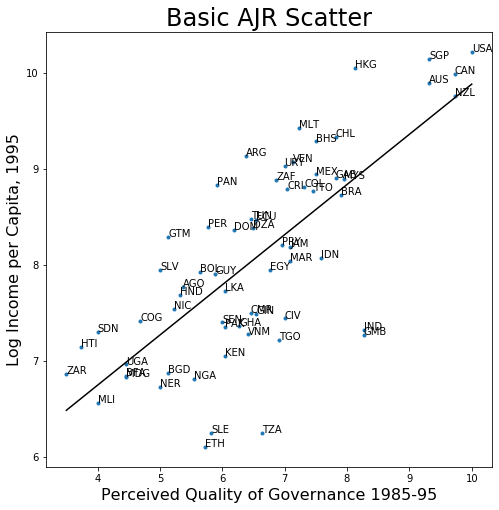

In [22]:
# 8.6.1. governance quality & prosperity: basic scatter plot

# tell python to expect figures to come 
# by initializing the python objects to hold the figures...

fig, ax = plt.subplots(figsize=(8,8)) 

# create the figure with average expropriation risk on the horizontal and
# 1995 per capita real income on the vertical axis

ax.scatter(ajr_df['governancequality'], ajr_df['logincome'], marker='.')

# now loop through the data[points in the figure, annotating each
# data point with a three letter code ('Threeletterabbrevation') identifying the 
# country refered to:

for i, txt in enumerate(ajr_df['shortid']):
    ax.annotate(txt, (ajr_df['governancequality'].iloc[i], ajr_df['logincome'].iloc[i]))
    

# draw a straight least-squares fit line through the data

ax.plot(np.unique(ajr_df['governancequality']),
    np.poly1d(np.polyfit(ajr_df['governancequality'], ajr_df['logincome'], 1))(np.unique(ajr_df['governancequality'])),
    color='black')

# set the figure labels, and show the figure:


ax.set_xlabel('Perceived Quality of Governance 1985-95', size=16)
ax.set_ylabel('Log Income per Capita, 1995', size=16)
ax.set_title('Basic AJR Scatter', size=24)
plt.show()

One thing we might do is to look at and think about "outliers" that are off the scatter relationship.

For example: Panama, El Salvador, Guatemala, Argentina, Peru, Malta, and Hong Kong were all somewhat richer in 1995 than the standard scatter would have led us to expect. We can ask the questions: Why are they different? Is it that something interrupted the chain of transmission from prosperity to governance quality, so they wound up with worse governance quality than their prosperity should have produce? Or is it that some special benefit gave them more prosperity than their governance quality should otherwise have been able to support?

Conversely: Nigeria, Togo, Cote d'Ivoire, Vietnam, Kenya, Tanzania, Sierra Leone, the Gambia, Ethiopia, and India are all poorer in 1995 than their governance quality would have led us to anticipate. Did something good happen to governance, giving them better governance than their prosperity fundamentals would have normally generated? Or did something bad happen to their levels of income to depress it?

In this case, we are looking at historical events that disrupted normal patterns of causation. 

Another thing we might do is look at the influential observations that follow the scatter relationship. We know a great deal about the U.S., Canada, Australia, New Zealand, and Singapore. Are they prosperous because they have high-quality governance? Or do they have high-quality governance because they are prosperous? Conversely, the worst-off countries in the world in 1995 in both governance and prosperity were the Congo, the Democratic Republic of the Congo, Mali, Haiti, Sudan, Madagascar, Niger, Uganda, and Bangladesh. Were they, predominatly, poor beause they had low-quality governance? Or did they have low-quality governance predominately because they were poor?

In the markdown cell below, in place of the ellipsis ("...") after the blue **<span style="color:blue;">"ANSWER:"</span>**, please write 250-500 words about what you think we learn about the value of β from this (first part of) Acemoglu, Johnson, and Robinson's analysis.

<span style="color:blue;">**ANSWER**: ...
</span>

## 7. Done!

Print your finished notebook to pdf, and upload it as an answer on the problem set 8 assignment page. URL: 

In [19]:
# 8.7.1. results summary cell

print("$",y_govqualis4, "/per year   is the annual income per capita level for a governance-quality index of 4")
print("Increasing governance quality by one multiplies expected income by a factor of:", oneunitincomemult)

for i in range(7): 
    print("For a governance quality of", govqual[i], ", expected income per capita is:", expinc[i])

    

$ 853.0345066875342 /per year   is the annual income per capita level for a governance-quality index of 4
Increasing governance quality by one multiplies expected income by a factor of: 1.6853950712974088
For a governance quality of 4 , expected income per capita is: 852.6933611185216
For a governance quality of 5 , expected income per capita is: 1437.1251881571782
For a governance quality of 6 , expected income per capita is: 2422.12370895747
For a governance quality of 7 , expected income per capita is: 4082.235361149513
For a governance quality of 8 , expected income per capita is: 6880.179357557402
For a governance quality of 9 , expected income per capita is: 11595.820378869399
For a governance quality of 10 , expected income per capita is: 19543.538514196578


&nbsp;

## 8. Appendix: Programming Dos and Don'ts...

### A Running List...

1. **Do** restart your kernel and run cells up to your current working point every fifteen minutes or so. Yes, it takes a little time. But if you don't, sooner or later the machine's namespace will get confused, and then you will get confused about the state of the machine's namespace, and by assuming things about it that are false you will lose hours and hours...   
&nbsp;

2. **Do** reload the page when restarting the kernel does not seem to do the job...   
&nbsp;

3. **Do** edit code cells by copying them below your current version and then working on the copy: when you break everything in the current cell (as you will), you can then go back to the old cell and start fresh...   
&nbsp;

4. **Do** exercise agile development practices: if there is a line of code that you have not tested, test it. The best way to test is to ask the machine to echo back to you the thing you have just created in its namespace to make sure that it is what you want it to be. Only after you are **certain** that your namespace contains what you think it does should you write the next line of code. And then you should immediately test it...   
&nbsp;

5. **Do** take screenshots of your error messages...   
&nbsp;

6. **Do** google your error messages: Ms. Google is your best friend here...   
&nbsp;

7. **Do not** confuse assignment ("=") and test for equality ("=="). In general, if there is an "if" anywhere nearby, you should be testing for equality. If there is not, you should be assignment a variable in your namespace to a value. **Do** curse the mathematicians 500 years ago who did not realize that in the twenty-first century it would be very convenient if we had different and not confusable symbols for equals-as-assignment and equals-as-test...   
&nbsp;

----

&nbsp;

**Thanks to**: Rachel Grossberg, Christopher Hench, Meghana Krishnakumer, Seth Lloyd, Ronald Walker...

----

&nbsp;

## <font color="880000"> Governance & Prosperity </font>

<img src="https://tinyurl.com/20190119a-delong" width="300" style="float:right" />

### <font color="000088">Catch Our Breath—Further Notes:</font>

<br clear="all" />

----



&nbsp;

----